In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
mf_data = pd.read_csv("midfielder_data.csv")
gk_data = pd.read_csv("goalkeeper_data.csv")
df_data = pd.read_csv("defender_data.csv")
at_data = pd.read_csv("attacker_data.csv")

In [146]:
#do some renaming
mf_data.columns = mf_train.columns.str.replace('.', '_')
mf_data.columns = mf_train.columns.str.replace('___', '_')
mf_data.columns = mf_train.columns.str.replace(' ', '_')

gk_data.columns = mf_train.columns.str.replace('.', '_')
gk_data.columns = mf_train.columns.str.replace('___', '_')
gk_data.columns = mf_train.columns.str.replace(' ', '_')

/var/folders/x_/pzlfspq52sd41dygb97kcztm0000gn/T/ipykernel_8271/978511297.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mf_data.columns = mf_train.columns.str.replace('.', '_')


ValueError: Length mismatch: Expected axis has 16 elements, new values have 14 elements

In [147]:
mf_data.columns

Index(['Name', 'Age', 'Overall.rating', 'Potential', 'Years Left',
       'field_position', 'Value', 'Wage', 'Skill.moves', 'Weak.foot',
       'Total.attacking', 'Total.skill', 'Total.movement', 'Total.power',
       'Total.mentality', 'Total.defending'],
      dtype='object')

<AxesSubplot: xlabel='Overall_rating', ylabel='Value'>

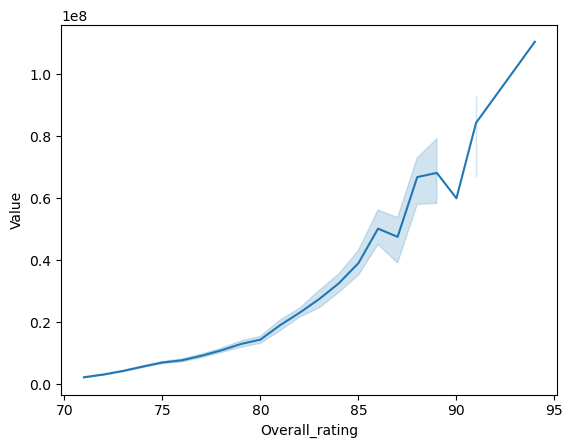

In [148]:
sns.lineplot(data = train, x = "Overall_rating", y = "Value")

<AxesSubplot: xlabel='Years_Left', ylabel='Value'>

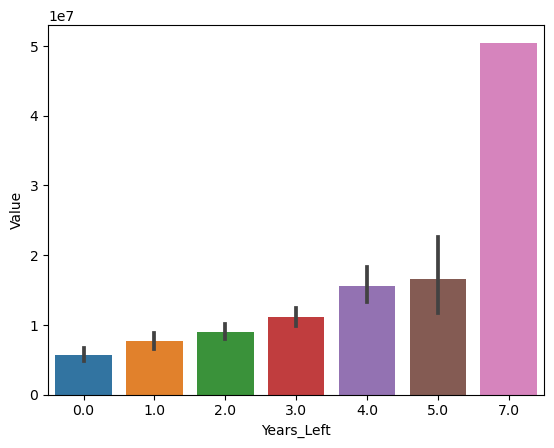

In [149]:
sns.barplot(data = train, x = "Years_Left", y = "Value")

<AxesSubplot: xlabel='Skill_moves', ylabel='Value'>

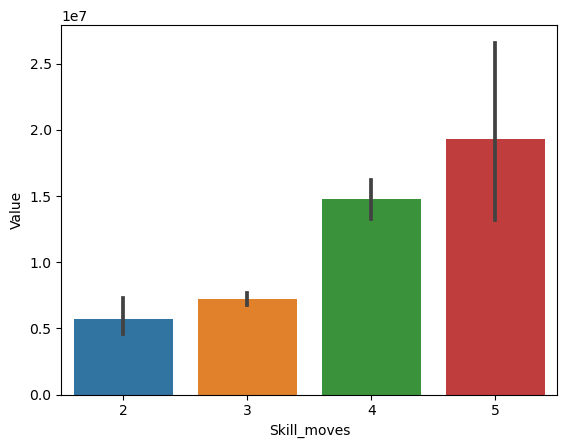

In [150]:
sns.barplot(data = train, x = "Skill_moves", y = "Value")

In [151]:
#sns.lineplot(data = train, x = "h", y = "Value")

In [152]:
mf_data = mf_data.drop(["field_position"], axis = 1)
mf_data = mf_data.drop(["Name"], axis = 1)
mf_data = mf_data.dropna() #drops NA Values

In [153]:
from sklearn.model_selection import train_test_split
mf_train, mf_test = train_test_split(mf_data, test_size = .2, shuffle = True)


#getting the target vector
X_train = mf_train.drop(["Value"], axis = 1)
y_train = mf_train["Value"]

X_test = mf_test.drop(["Value"], axis = 1)
y_test = mf_test["Value"]

In [154]:
#from sklearn.preprocessing import StandardScaler
#sc = StandardScaler()
#normalized_X_train = sc.fit_transform(X_train)

In [155]:
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test,y_test)

0.8837372690734915

In [156]:
gk_data = gk_data.drop(["field_position"], axis = 1)
gk_data = gk_data.drop(["Name"], axis = 1)
gk_data = gk_data.dropna() #drops NA Values

In [180]:
from sklearn.model_selection import train_test_split
gk_train, gk_test = train_test_split(gk_data, test_size = .2, shuffle = True)


#getting the target vector
X_train_gk = gk_train.drop(["Value"], axis = 1)
y_train_gk = gk_train["Value"]

X_test_gk = gk_test.drop(["Value"], axis = 1)
y_test_gk = gk_test["Value"]

In [181]:

from sklearn.linear_model import LinearRegression

reg2 = LinearRegression().fit(X_train_gk, y_train_gk)
reg2.score(X_test_gk,y_test_gk)

0.8576258989615555

Incentives:

Should come from:
- Regulation
- Collective pressure from workers(unionizing) or investors

Opportunity costs:
All money going to the "big" research projects
Military as biggest investor in AI, government sector investing pushing the field
- Whatever you build will favor that by default
Unquestioned assumption that models have benefits; null hypothesis
- Need proof that a model will be beneficial

Effective systems of refusal:
High risk for not being "super online"
Should have a right to not parcitipate
Can ban something for being bad for society
Getting rid of the belief of inevitability; the evolution of tech didn't happen by chance, so we can be intentional in fighing against it if need be

Steps individual developers can take to not be part of this bad system:
Leave the field
- Most scientists/engineers are aligned with power
Use tools to help the little person

How would computer vision develop differently if there was benevolent social planner:
It would not exist
- Perhaps more decentralized
- Perhaps less computationally and work-intensive models

Understanding the scope of underpriviliged people's problems; How is AI gonna help someone get water for their kids.
Those who label the datasets we use in computer vision are not compensated accordingly; 




Dair's Pillars

1. Mitigating harms of current "AI" systems

AI colonionalism

Exploited labor behind AI
- Supplying Data
- Content Moderation
- Data Labeling

Utopia for who?

AGI vs. AI

AGI, who defines its characteristics 


Eugenics debrief

Rooted in 20th century eugenics tradition.

Brief introduction into eugenics
Second-wave 


AGI Utopia
AGI Apocalypse

Eugenics is popular thing amongst scientists; didn't go away, reinvents itself

First-Wave Eugenics
- Remove the weak (negative eugenics)

Second-Wave Eugenics (Sam Altman)
- Give people ability to design their children (positive eugenics)
- Aim to trascend humanity all together
- People can choose to radically enchane thmeselves and becomme "posthuman"; a new superior species can be created

Properties of TESCREAL Bundle

Singularitsm
- "event horizon"
- "an intelligence explosion"
 
Cosmism
- humans will merge with tech
- develop sentient AI
- spread to the stars and roam the universe

Properties of TESCREAL Bundle
1) Historical roots & contemporary communities

2) Eschatology
    - Utopia (lolol) 
        - Worried about transcending our frail bodies, but can't use that insane tech to help better ppl's situation
    - Apocalyptic
    - Discriminatory Views
        - 
    - Influence

AGI History

2007, "christen" the term AGI, TESCREAList Ben Goertzel & Pennachin



AGI Utopia
Scenario 1: AGI will be so intelligent that it will be figure out waht to do in any scenario -> world peace?

Scenario 2: "Morally superior" AGI enhanced transhuman minds benefitting


AGI Utopia... for whom? perpetuating biases

- text-to-image models being used for deepfakes, overly sexualizing woman...

!!!Having everyone pay one company for as many services as possible (subpar work); conglomerates vs. helping specific communities (good work); individual!!!

Their dataset was the output of other translation system. 

NOT UTOPIA FOR MOST OF US

AGI Apocalypse

Not a SCI-FI thing. Not a machine gaining "autonomy" and destroying humanity. There are systems driving the "machines" down these dangerous paths
- Corporations funding, environment being harmed, datasets being stolen, workers being exploited

STOP separating the machines from the humans


AGI and religion paper
Why do ppl who claim to be non-religious, have such religious rhetoric when describing the AGI Utopia.

Unscoped; move to narrowly defined specific use-cases


create coalitions advocating for shared goals